# Analysis of FAIR metrics

In this notebook, the retrieved results of the FAIR metrics collection is analyzed.

In [1]:
from datetime import date
import statistics
from collections import Counter
from pathlib import Path
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import table 
import matplotlib.pyplot as plt
import matplotlib.table as table
import seaborn as sns
from scipy import stats

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})

Folders and constants

In [3]:
subset = "all"  # "user", "group", "all"

# todo make this into something nice
how_fair_is = pd.read_csv("output/repositories_howfairis.csv")
languages = pd.read_csv("output/languages.csv")
contributors = pd.read_csv("output/contributors.csv")
topics = pd.read_csv("output/topics.csv")

# file paths
fp_repos = Path("..", "collect_repositories", "results", "repositories_filtered.csv")
fp_figs = Path("figs")

# create output folder if not exists
fp_figs.mkdir(exist_ok=True)

In [4]:
subset

'group'

## Load filtered repositories
Load (manually) filtered repositories into notebook.

In [5]:
repos = pd.read_csv(fp_repos)

## Filtering for research groups or private users only

In [6]:
users = pd.read_excel("../collect_users/results/users_enriched.xlsx")

In [7]:
def add_research_group_filter(dataset):
    user_is_research_group = []
    for row in dataset.iterrows():
        try:
            owner = row[1]['owner']
        except:
            owner = row[1]['html_url_repository'].split('/')[-2]
            
            
      
        row_users = users.loc[users['user_id'] == owner]
        if len(row_users['is_research_group']) == 0:
            user_is_research_group.append(False)
        for i in row_users['is_research_group']:
            if i == 1:
                user_is_research_group.append(True)
                break
            else:
                user_is_research_group.append(False)
                break
                    
    return user_is_research_group
    

In [8]:
repos['is_research_group'] = add_research_group_filter(repos)
contributors['is_research_group'] = add_research_group_filter(contributors)
topics['is_research_group'] = add_research_group_filter(topics)
languages['is_research_group'] = add_research_group_filter(languages)
how_fair_is['is_research_group'] = add_research_group_filter(how_fair_is)

## Subset repositories
Make a subset of repositories on "user", "group", or "all".

- "user" - Account of individual researcher
- "group" - Account of research group
- "all" - Both individual researcher or research group

In [9]:
if subset == "user":
    repos = repos[~repos['is_research_group']]
    contributors = contributors[~contributors['is_research_group']]
    topics = topics[~topics['is_research_group']]
    languages = languages[~languages['is_research_group']]
    how_fair_is = how_fair_is[~how_fair_is['is_research_group']]
elif subset == "group":
    repos = repos[repos['is_research_group']]
    contributors = contributors[contributors['is_research_group']]
    topics = topics[topics['is_research_group']]
    languages = languages[languages['is_research_group']]
    how_fair_is = how_fair_is[how_fair_is['is_research_group']]

## Datasets

Using the github API and the Howfairis software, we collected data on the repositories, their FAIRness, the languages used in the repository, the amount of contributors for each repository and the topics mentoined in each repository. 

The Howfairis software gives  boolean value on five measures of FAIRness for each repository. These five measures consist of having a repository (which is always True for our dataset), having a license, being available in a registry, allowing citation of the software and following the FAIR software quality checklist. Below, the first five rows of the datasets are displayed. 

In [10]:
repos

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,is_template,topics,visibility,forks,open_issues,watchers,default_branch,permissions,date,is_research_group
51,157202219,MDEwOlJlcG9zaXRvcnkxNTcyMDIyMTk=,callmice,amices/callmice,False,amices,https://github.com/amices/callmice,Test and demonstrates how to use mice in your ...,False,https://api.github.com/repos/amices/callmice,...,False,[],public,1,0,1,master,NaN,2022-01-14,True
52,159842075,MDEwOlJlcG9zaXRvcnkxNTk4NDIwNzU=,dsMice,amices/dsMice,False,amices,https://github.com/amices/dsMice,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMice,...,False,"['chained-equations', 'datashield', 'imputatio...",public,1,0,2,master,NaN,2022-01-14,True
53,159489076,MDEwOlJlcG9zaXRvcnkxNTk0ODkwNzY=,dsMiceClient,amices/dsMiceClient,False,amices,https://github.com/amices/dsMiceClient,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMiceClient,...,False,"['chained-equations', 'datashield', 'imputatio...",public,1,1,0,master,NaN,2022-01-14,True
54,8910139,MDEwOlJlcG9zaXRvcnk4OTEwMTM5,mice,amices/mice,False,amices,https://github.com/amices/mice,Multivariate Imputation by Chained Equations,False,https://api.github.com/repos/amices/mice,...,False,"['chained-equations', 'fcs', 'imputation', 'mi...",public,79,25,273,master,NaN,2022-01-14,True
55,187627582,MDEwOlJlcG9zaXRvcnkxODc2Mjc1ODI=,mice3paper,amices/mice3paper,False,amices,https://github.com/amices/mice3paper,Materials documenting some facilities in mice 3,False,https://api.github.com/repos/amices/mice3paper,...,False,[],public,0,0,0,master,NaN,2022-01-14,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,337555188,MDEwOlJlcG9zaXRvcnkzMzc1NTUxODg=,osmenrich,sodascience/osmenrich,False,sodascience,https://github.com/sodascience/osmenrich,Enrich sf data with geographic features from O...,False,https://api.github.com/repos/sodascience/osmen...,...,False,"['geospatial', 'geospatial-data', 'odissei', '...",public,2,4,8,main,NaN,2022-01-14,True
1047,338014671,MDEwOlJlcG9zaXRvcnkzMzgwMTQ2NzE=,osmenrich_docker,sodascience/osmenrich_docker,False,sodascience,https://github.com/sodascience/osmenrich_docker,Setup local OSRM and Overpass API endpoints us...,False,https://api.github.com/repos/sodascience/osmen...,...,False,"['docker', 'osrm', 'overpass-api', 'soda-scien...",public,0,0,3,master,NaN,2022-01-14,True
1048,333718109,MDEwOlJlcG9zaXRvcnkzMzM3MTgxMDk=,presentation-osmenrich-sig,sodascience/presentation-osmenrich-sig,False,sodascience,https://github.com/sodascience/presentation-os...,Presentation for the UU special interest group...,False,https://api.github.com/repos/sodascience/prese...,...,False,"['data-science', 'geospatial', 'software']",public,0,1,1,main,NaN,2022-01-14,True
1401,199618365,MDEwOlJlcG9zaXRvcnkxOTk2MTgzNjU=,development-API,vitality-data-center/development-API,False,vitality-data-center,https://github.com/vitality-data-center/develo...,NaN,False,https://api.github.com/repos/vitality-data-cen...,...,False,[],public,1,0,1,master,NaN,2022-01-14,True


In [11]:
how_fair_is

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,watchers,default_branch,permissions,date,howfairis_repository,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist,is_research_group
51,157202219,MDEwOlJlcG9zaXRvcnkxNTcyMDIyMTk=,callmice,amices/callmice,False,amices,https://github.com/amices/callmice,Test and demonstrates how to use mice in your ...,False,https://api.github.com/repos/amices/callmice,...,1,master,NaN,2022-01-16,True,False,False,False,False,True
52,159842075,MDEwOlJlcG9zaXRvcnkxNTk4NDIwNzU=,dsMice,amices/dsMice,False,amices,https://github.com/amices/dsMice,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMice,...,2,master,NaN,2022-01-16,True,False,False,False,False,True
53,159489076,MDEwOlJlcG9zaXRvcnkxNTk0ODkwNzY=,dsMiceClient,amices/dsMiceClient,False,amices,https://github.com/amices/dsMiceClient,Multivariate Imputation by Chained Equations f...,False,https://api.github.com/repos/amices/dsMiceClient,...,0,master,NaN,2022-01-16,True,False,False,False,False,True
54,8910139,MDEwOlJlcG9zaXRvcnk4OTEwMTM5,mice,amices/mice,False,amices,https://github.com/amices/mice,Multivariate Imputation by Chained Equations,False,https://api.github.com/repos/amices/mice,...,273,master,NaN,2022-01-16,True,False,True,False,False,True
55,187627582,MDEwOlJlcG9zaXRvcnkxODc2Mjc1ODI=,mice3paper,amices/mice3paper,False,amices,https://github.com/amices/mice3paper,Materials documenting some facilities in mice 3,False,https://api.github.com/repos/amices/mice3paper,...,0,master,NaN,2022-01-16,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,337555188,MDEwOlJlcG9zaXRvcnkzMzc1NTUxODg=,osmenrich,sodascience/osmenrich,False,sodascience,https://github.com/sodascience/osmenrich,Enrich sf data with geographic features from O...,False,https://api.github.com/repos/sodascience/osmen...,...,8,main,NaN,2022-01-16,True,True,False,True,False,True
1047,338014671,MDEwOlJlcG9zaXRvcnkzMzgwMTQ2NzE=,osmenrich_docker,sodascience/osmenrich_docker,False,sodascience,https://github.com/sodascience/osmenrich_docker,Setup local OSRM and Overpass API endpoints us...,False,https://api.github.com/repos/sodascience/osmen...,...,3,master,NaN,2022-01-16,True,True,False,False,False,True
1048,333718109,MDEwOlJlcG9zaXRvcnkzMzM3MTgxMDk=,presentation-osmenrich-sig,sodascience/presentation-osmenrich-sig,False,sodascience,https://github.com/sodascience/presentation-os...,Presentation for the UU special interest group...,False,https://api.github.com/repos/sodascience/prese...,...,1,main,NaN,2022-01-16,True,False,False,False,False,True
1401,199618365,MDEwOlJlcG9zaXRvcnkxOTk2MTgzNjU=,development-API,vitality-data-center/development-API,False,vitality-data-center,https://github.com/vitality-data-center/develo...,NaN,False,https://api.github.com/repos/vitality-data-cen...,...,1,master,NaN,2022-01-16,True,False,False,False,False,True


In [12]:
languages

,html_url_repository,language,num_chars,date,is_research_group
94,https://github.com/amices/callmice,R,1394,2022-01-16,True
95,https://github.com/amices/dsMice,R,64362,2022-01-16,True
96,https://github.com/amices/dsMice,TeX,754,2022-01-16,True
97,https://github.com/amices/dsMiceClient,R,80811,2022-01-16,True
98,https://github.com/amices/dsMiceClient,TeX,754,2022-01-16,True
...,...,...,...,...,...
1952,https://github.com/sodascience/osmenrich_docker,Shell,9214,2022-01-16,True
1953,https://github.com/sodascience/osmenrich_docker,Dockerfile,3496,2022-01-16,True
1954,https://github.com/sodascience/presentation-os...,R,9168,2022-01-16,True
2729,https://github.com/vitality-data-center/enviro...,Python,154167,2022-01-16,True


In [13]:
contributors

,html_url_repository,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,...,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin,contributions,date,is_research_group
164,https://github.com/amices/callmice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,3,2022-01-16,True
165,https://github.com/amices/dsMice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,12,2022-01-16,True
166,https://github.com/amices/dsMice,paularaissa,4760063,MDQ6VXNlcjQ3NjAwNjM=,https://avatars.githubusercontent.com/u/476006...,NaN,https://api.github.com/users/paularaissa,https://github.com/paularaissa,https://api.github.com/users/paularaissa/follo...,https://api.github.com/users/paularaissa/follo...,...,https://api.github.com/users/paularaissa/subsc...,https://api.github.com/users/paularaissa/orgs,https://api.github.com/users/paularaissa/repos,https://api.github.com/users/paularaissa/event...,https://api.github.com/users/paularaissa/recei...,User,False,4,2022-01-16,True
167,https://github.com/amices/dsMiceClient,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,22,2022-01-16,True
168,https://github.com/amices/mice,stefvanbuuren,3919919,MDQ6VXNlcjM5MTk5MTk=,https://avatars.githubusercontent.com/u/391991...,NaN,https://api.github.com/users/stefvanbuuren,https://github.com/stefvanbuuren,https://api.github.com/users/stefvanbuuren/fol...,https://api.github.com/users/stefvanbuuren/fol...,...,https://api.github.com/users/stefvanbuuren/sub...,https://api.github.com/users/stefvanbuuren/orgs,https://api.github.com/users/stefvanbuuren/repos,https://api.github.com/users/stefvanbuuren/eve...,https://api.github.com/users/stefvanbuuren/rec...,User,False,1007,2022-01-16,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1958,https://github.com/sodascience/presentation-os...,leonardovida,2588282,MDQ6VXNlcjI1ODgyODI=,https://avatars.githubusercontent.com/u/258828...,NaN,https://api.github.com/users/leonardovida,https://github.com/leonardovida,https://api.github.com/users/leonardovida/foll...,https://api.github.com/users/leonardovida/foll...,...,https://api.github.com/users/leonardovida/subs...,https://api.github.com/users/leonardovida/orgs,https://api.github.com/users/leonardovida/repos,https://api.github.com/users/leonardovida/even...,https://api.github.com/users/leonardovida/rece...,User,False,1,2022-01-16,True
2610,https://github.com/vitality-data-center/develo...,wzy19840102,5908465,MDQ6VXNlcjU5MDg0NjU=,https://avatars.githubuser

In [14]:
topics

,html_url_repository,topic,date,is_research_group
62,https://github.com/amices/dsMice,chained-equations,2022-01-16,True
63,https://github.com/amices/dsMice,datashield,2022-01-16,True
64,https://github.com/amices/dsMice,imputation,2022-01-16,True
65,https://github.com/amices/dsMice,mice,2022-01-16,True
66,https://github.com/amices/dsMiceClient,chained-equations,2022-01-16,True
...,...,...,...,...
892,https://github.com/sodascience/osmenrich_docker,utrecht-university,2022-01-16,True
893,https://github.com/sodascience/presentation-os...,data-science,2022-01-16,True
894,https://github.com/sodascience/presentation-os...,geospatial,2022-01-16,True
895,https://github.com/sodascience/presentation-os...,software,2022-01-16,True


In [15]:
print("The repository data from Github contains the following columns:")
print(repos.columns)

The repository data from Github contains the following columns:
Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url',
       'description', 'fork', 'url', 'forks_url', 'keys_url',
       'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url',
       'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url',
       'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url',
       'languages_url', 'stargazers_url', 'contributors_url',
       'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url',
       'comments_url', 'issue_comment_url', 'contents_url', 'compare_url',
       'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url',
       'milestones_url', 'notifications_url', 'labels_url', 'releases_url',
       'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url',
       'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size',
       'stargazers_count', 'watchers_count', 'language', 'has_i

## Different licenses 

A license is important because it shows that people have permission to use and modify your code. In our dataset,the most common one is MIT license, followed by GNU General Public license.  The plot below shows the value count of different licenses. 


In [16]:
licenses_abbr = {
    'MIT License': 'MIT',
    'GNU General Public License v3.0': 'GPLv3',
    'Other': 'Other',
    'Apache License 2.0': 'Apache 2.0',
    'GNU General Public License v2.0': 'GPLv2',
    'BSD 3-Clause "New" or "Revised" License': 'BSD 3-Clause',
    'Creative Commons Attribution 4.0 International': 'CC-BY',
    'Creative Commons Zero v1.0 Universal': 'CC0',
    'GNU Lesser General Public License v3.0': 'LGPLv3',
    'The Unlicense': 'Unlicense'
}

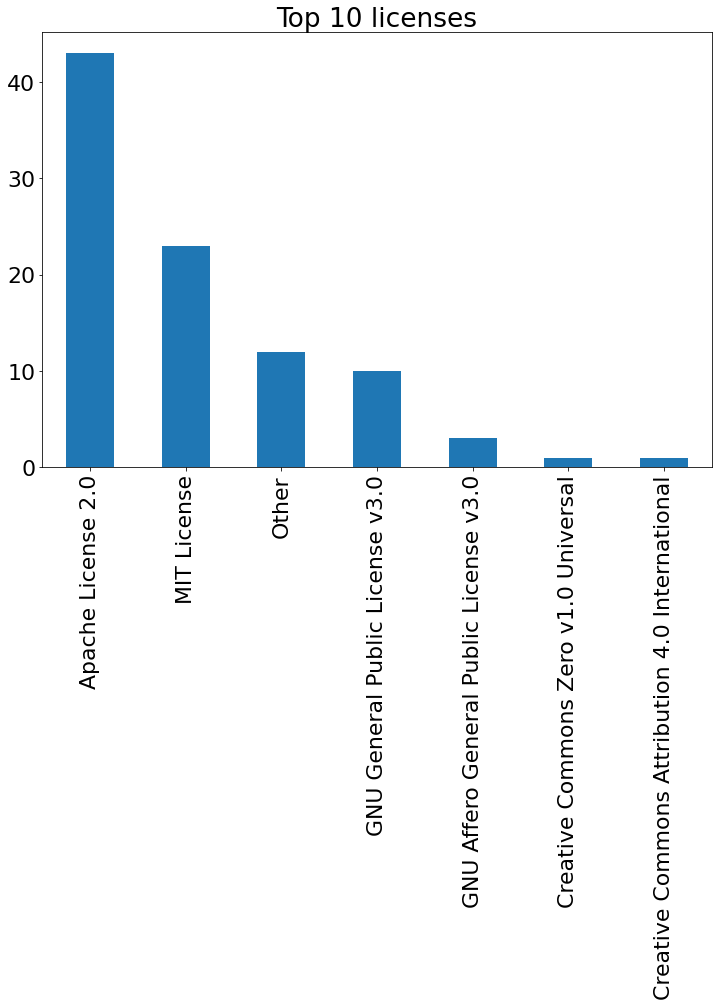

In [17]:
# first 10 licences
repos["license"].value_counts().head(10).plot(kind='bar', title='Top 10 licenses')
plt.savefig(Path(fp_figs, f'licenses_first10_{subset}.png'), bbox_inches="tight")

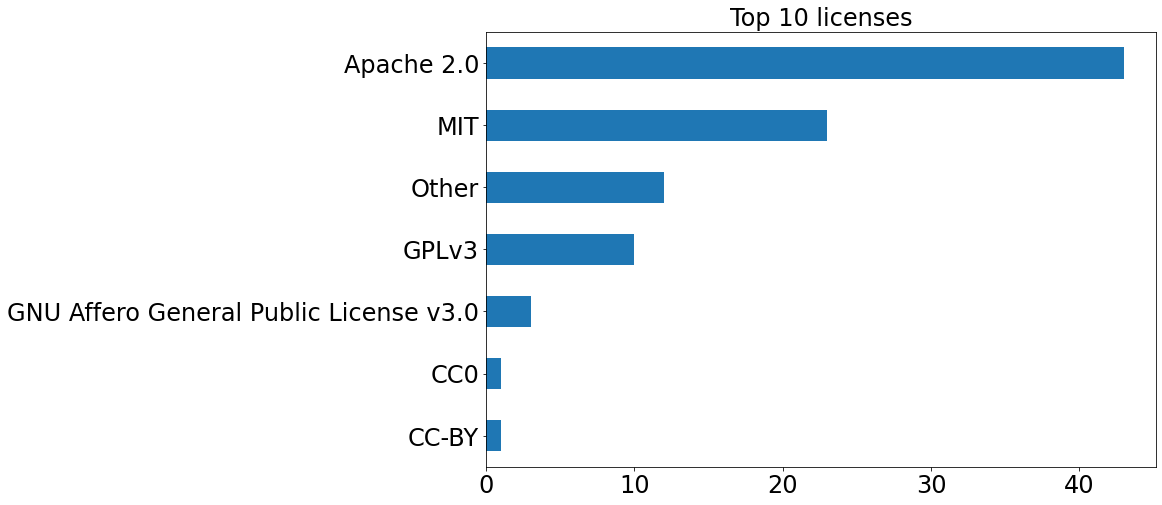

In [18]:
# first 10 licences with short names
ax = repos["license"].replace(licenses_abbr).value_counts().head(10).plot(kind='barh', title='Top 10 licenses')

plt.gca().invert_yaxis()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)
plt.savefig(Path(fp_figs, f'licenses_short_first10_{subset}.png'), bbox_inches="tight")

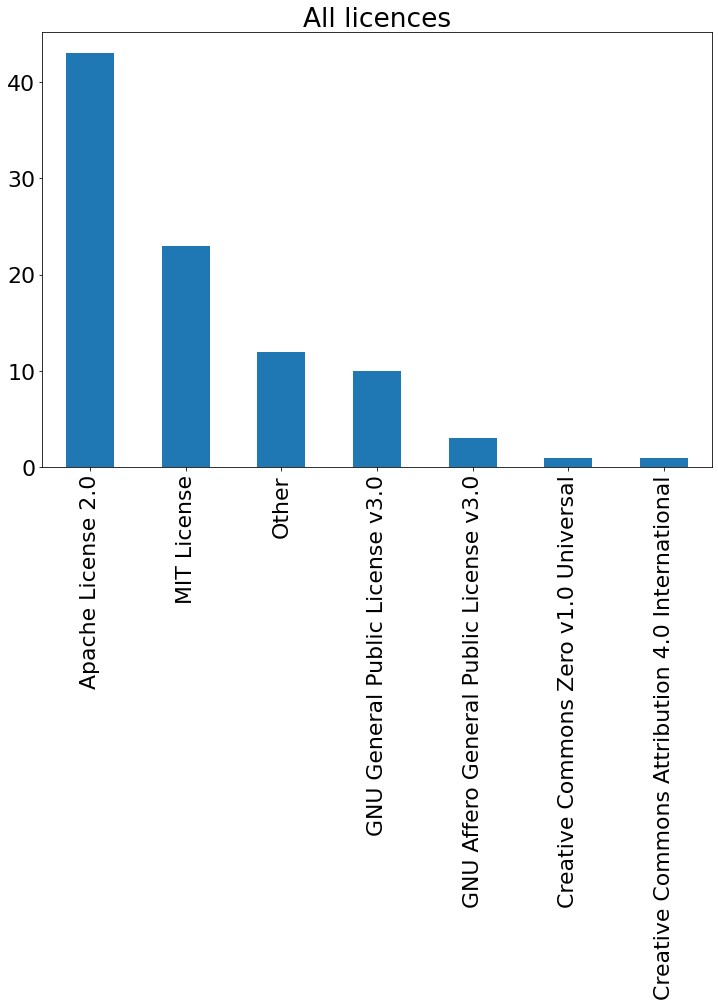

In [19]:
# all licences
repos["license"].value_counts().plot(kind='bar', title = 'All licences')
plt.savefig(Path(fp_figs, f'licenses_all_{subset}.png'), bbox_inches="tight")

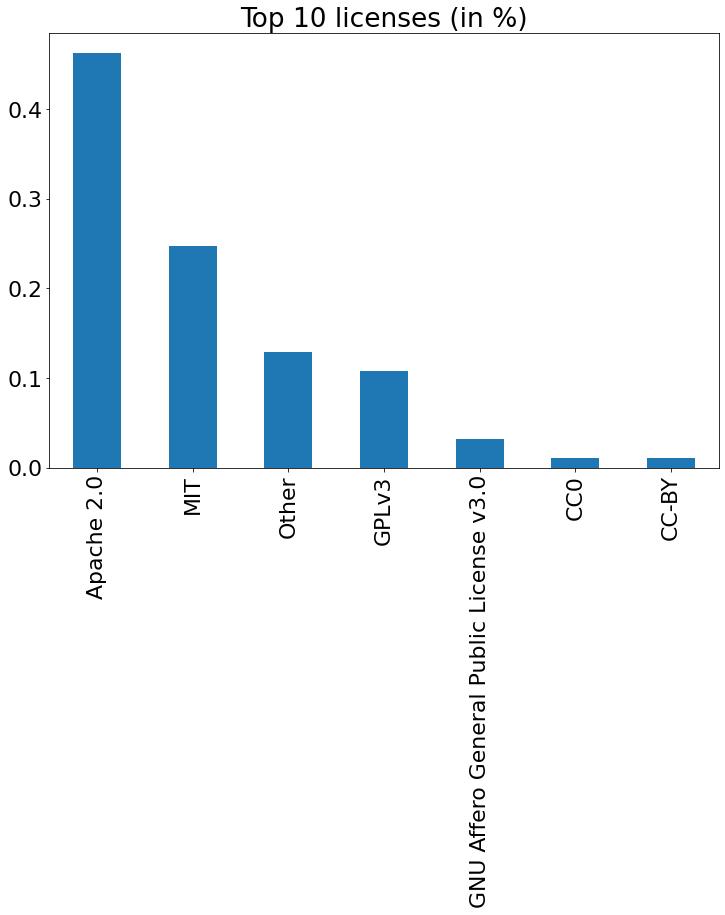

In [20]:
# first 10 licences with short names
repo_licenses_rel = repos["license"].replace(licenses_abbr).value_counts().head(10) / repos["license"].notnull().sum()
repo_licenses_rel.plot.bar(
    title='Top 10 licenses (in %)'
)
plt.savefig(Path(fp_figs, f'licenses_short_first10_percentage_{subset}.png'), bbox_inches="tight")

Below, the propotion of licenses compared to the total is shown, with their absolute count shown below that. . 

In [21]:
percentage_license = round(float(repos["license"].isna().sum()/len(repos)* 100),2)
print("{} % of repositories have a license on their page".format(percentage_license))

34.51 % of repositories have a license on their page


## Languages

The programming language that is used in the repository gives information on the type of project the repository is. data analysis is mostly done in R and Python, though Python is used for other purposes as well. 

### Jupyter Notebooks

Please note that due to the way GitHub calculates the dominant language in a repository, Jupyter Notebooks tend to be the top language if used in a repository. The top language is determined by the number of characters, which is usually much larger in Jupyter Notebook files compared to for example Python scripts.

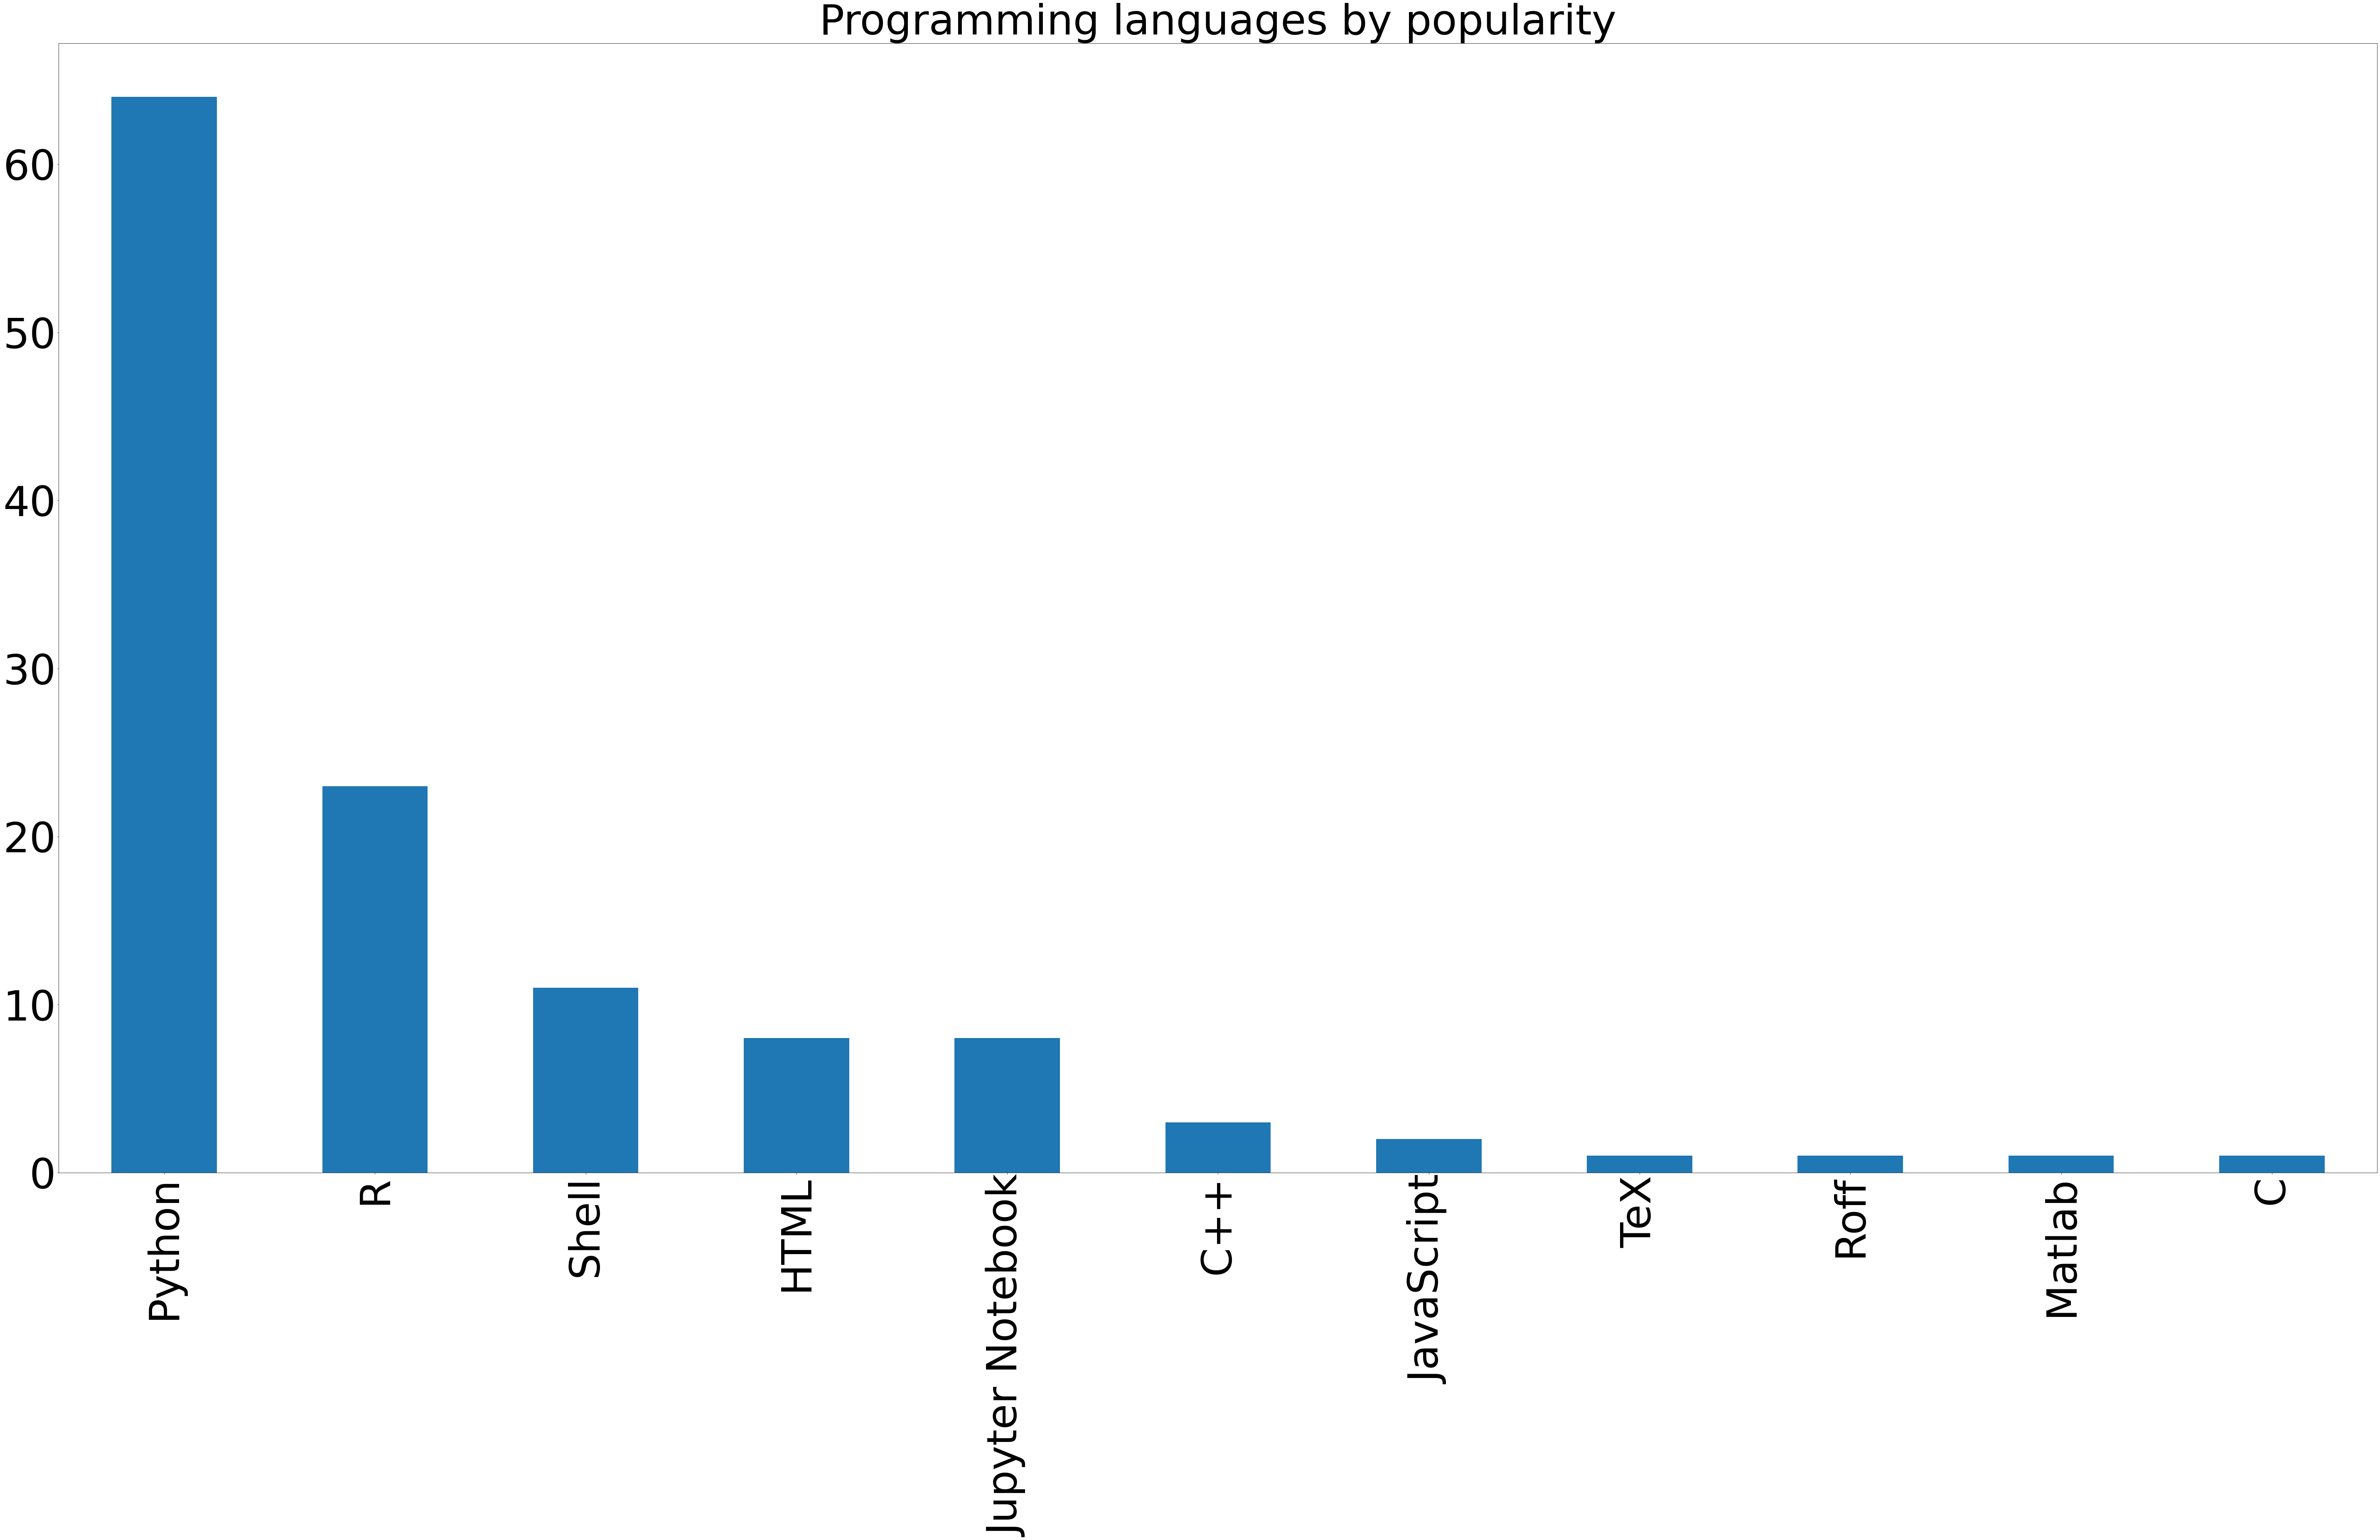

In [22]:
repos["language"].value_counts().plot.bar(figsize = (100,50), fontsize = 100)
plt.title("Programming languages by popularity", fontsize = 100)
plt.savefig(Path(fp_figs, f'language_{subset}.png'), bbox_inches="tight")

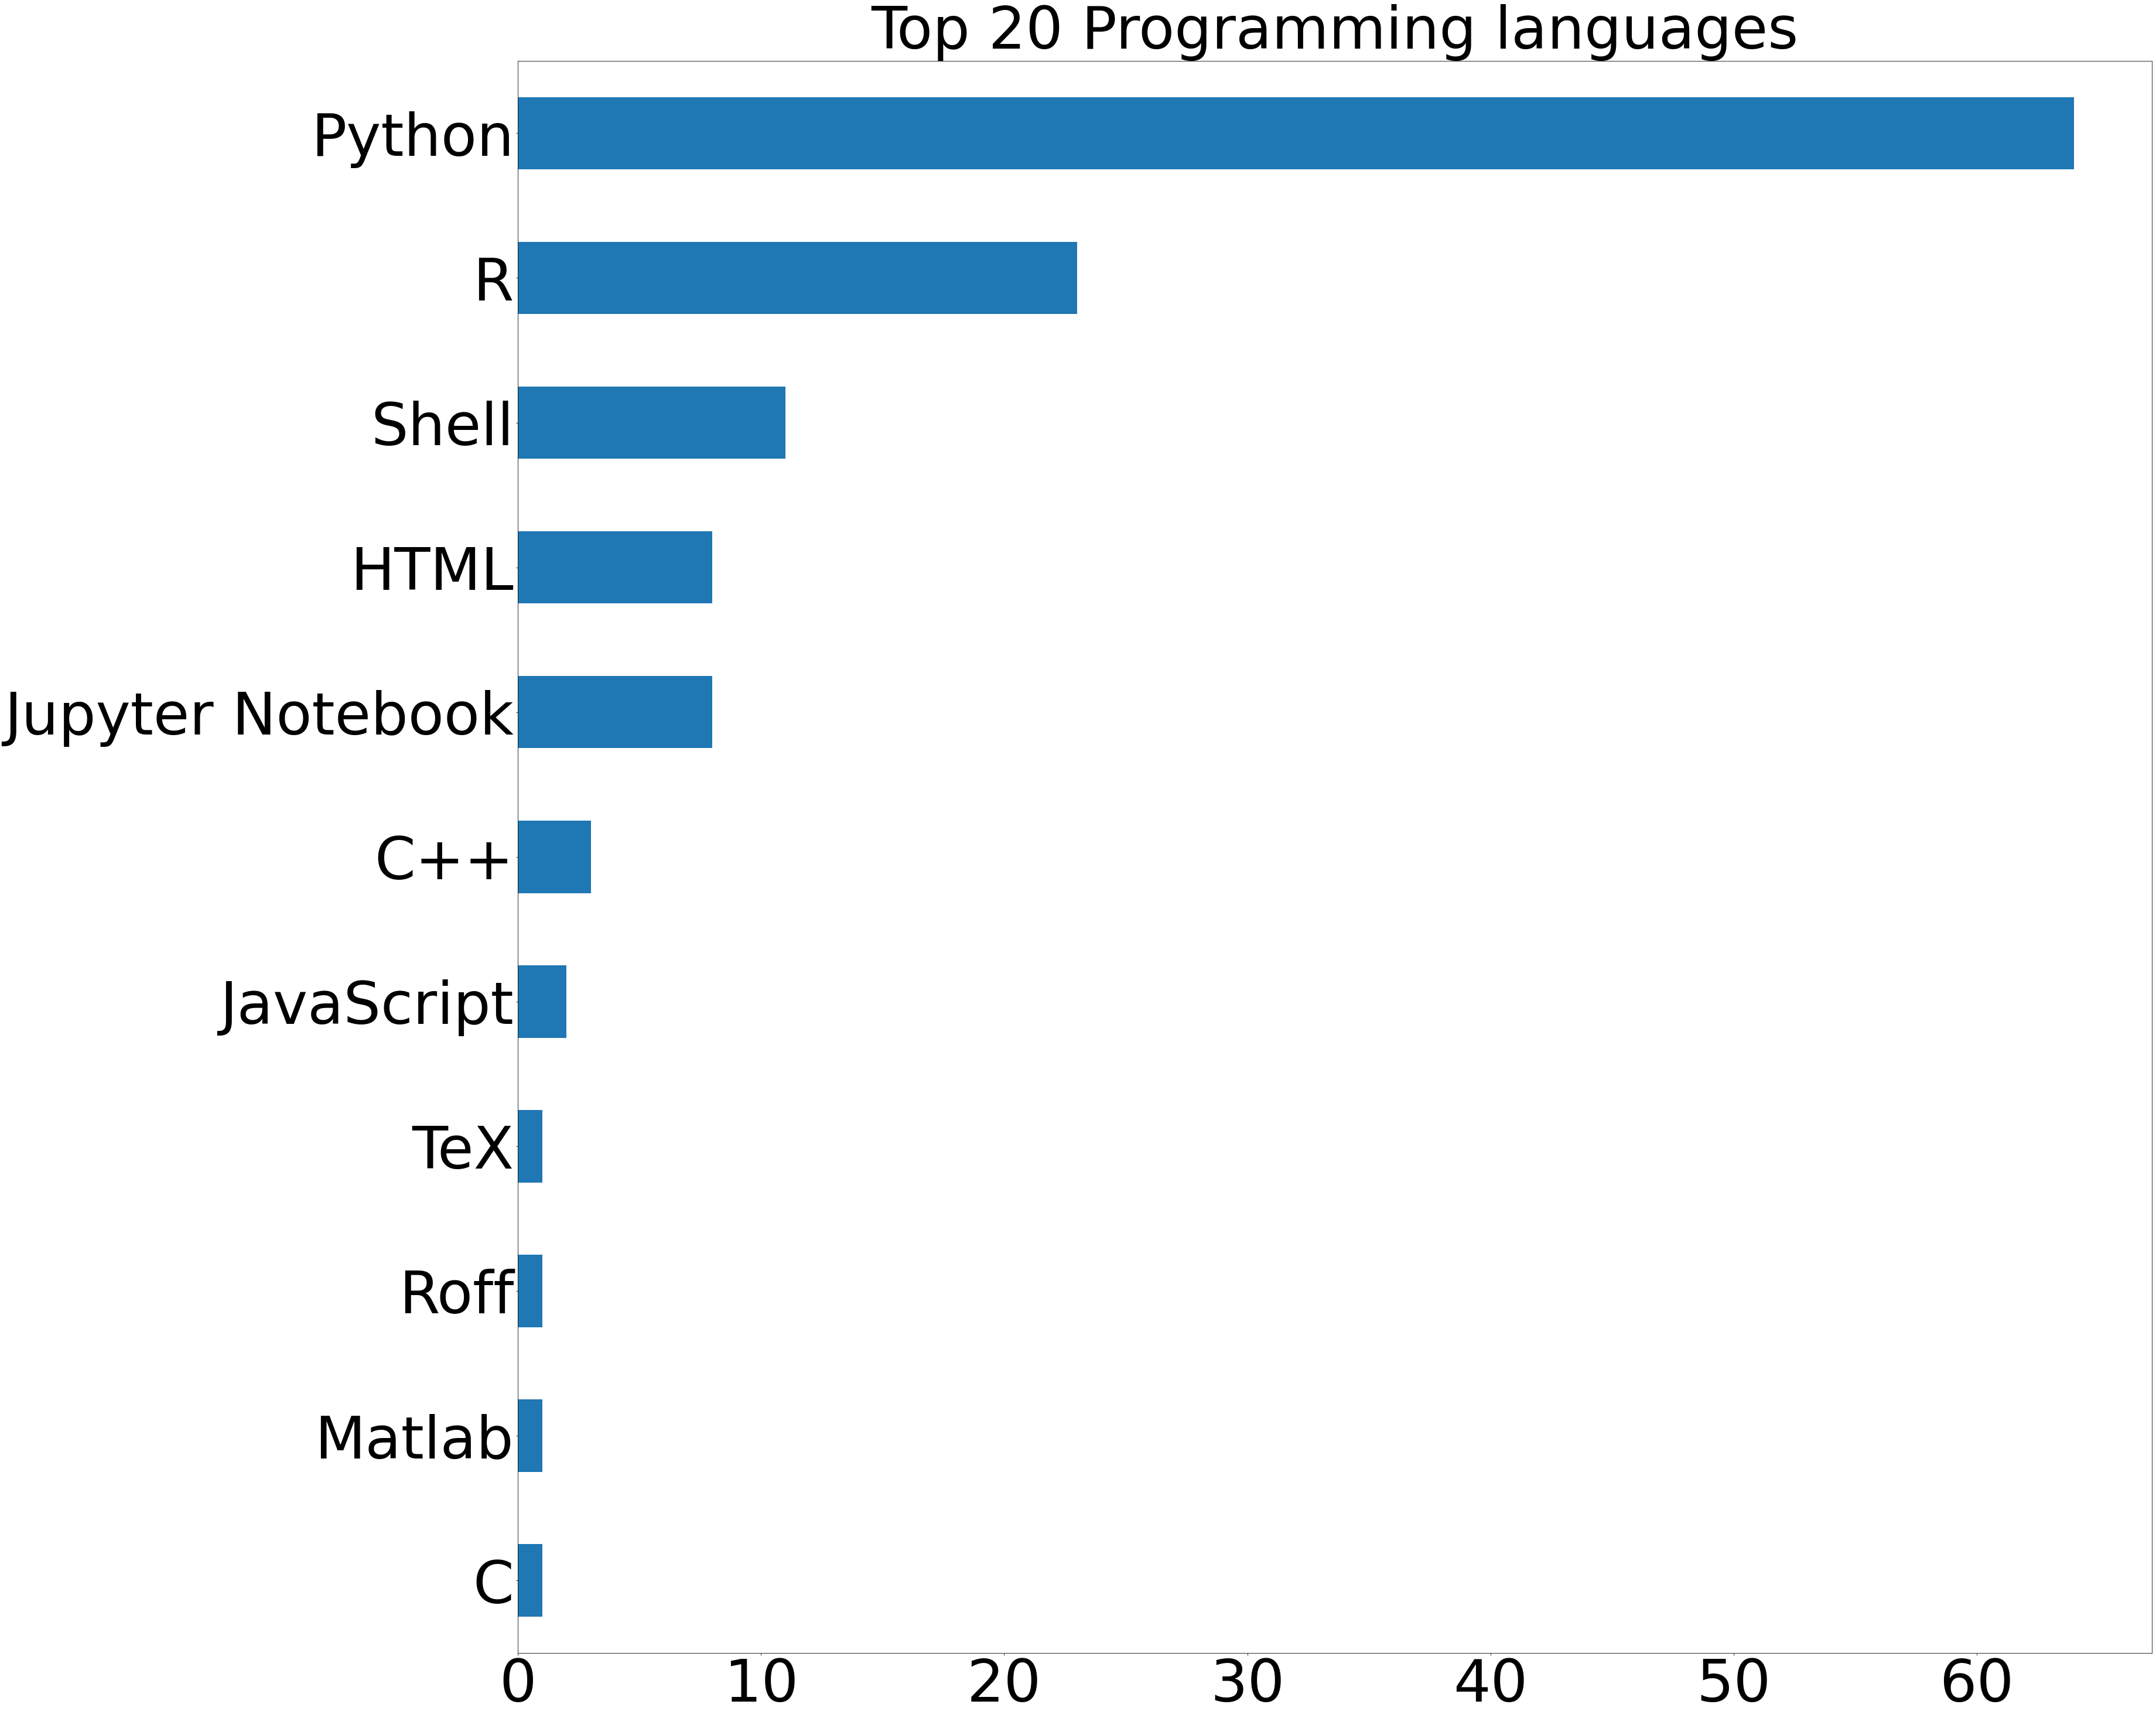

In [23]:
repos["language"].value_counts().head(20).plot.barh(figsize = (50,50), fontsize = 100)
plt.title("Top 20 Programming languages", fontsize = 100)
plt.gca().invert_yaxis()
plt.savefig(Path(fp_figs, f'language_top20_{subset}.png'), bbox_inches="tight")

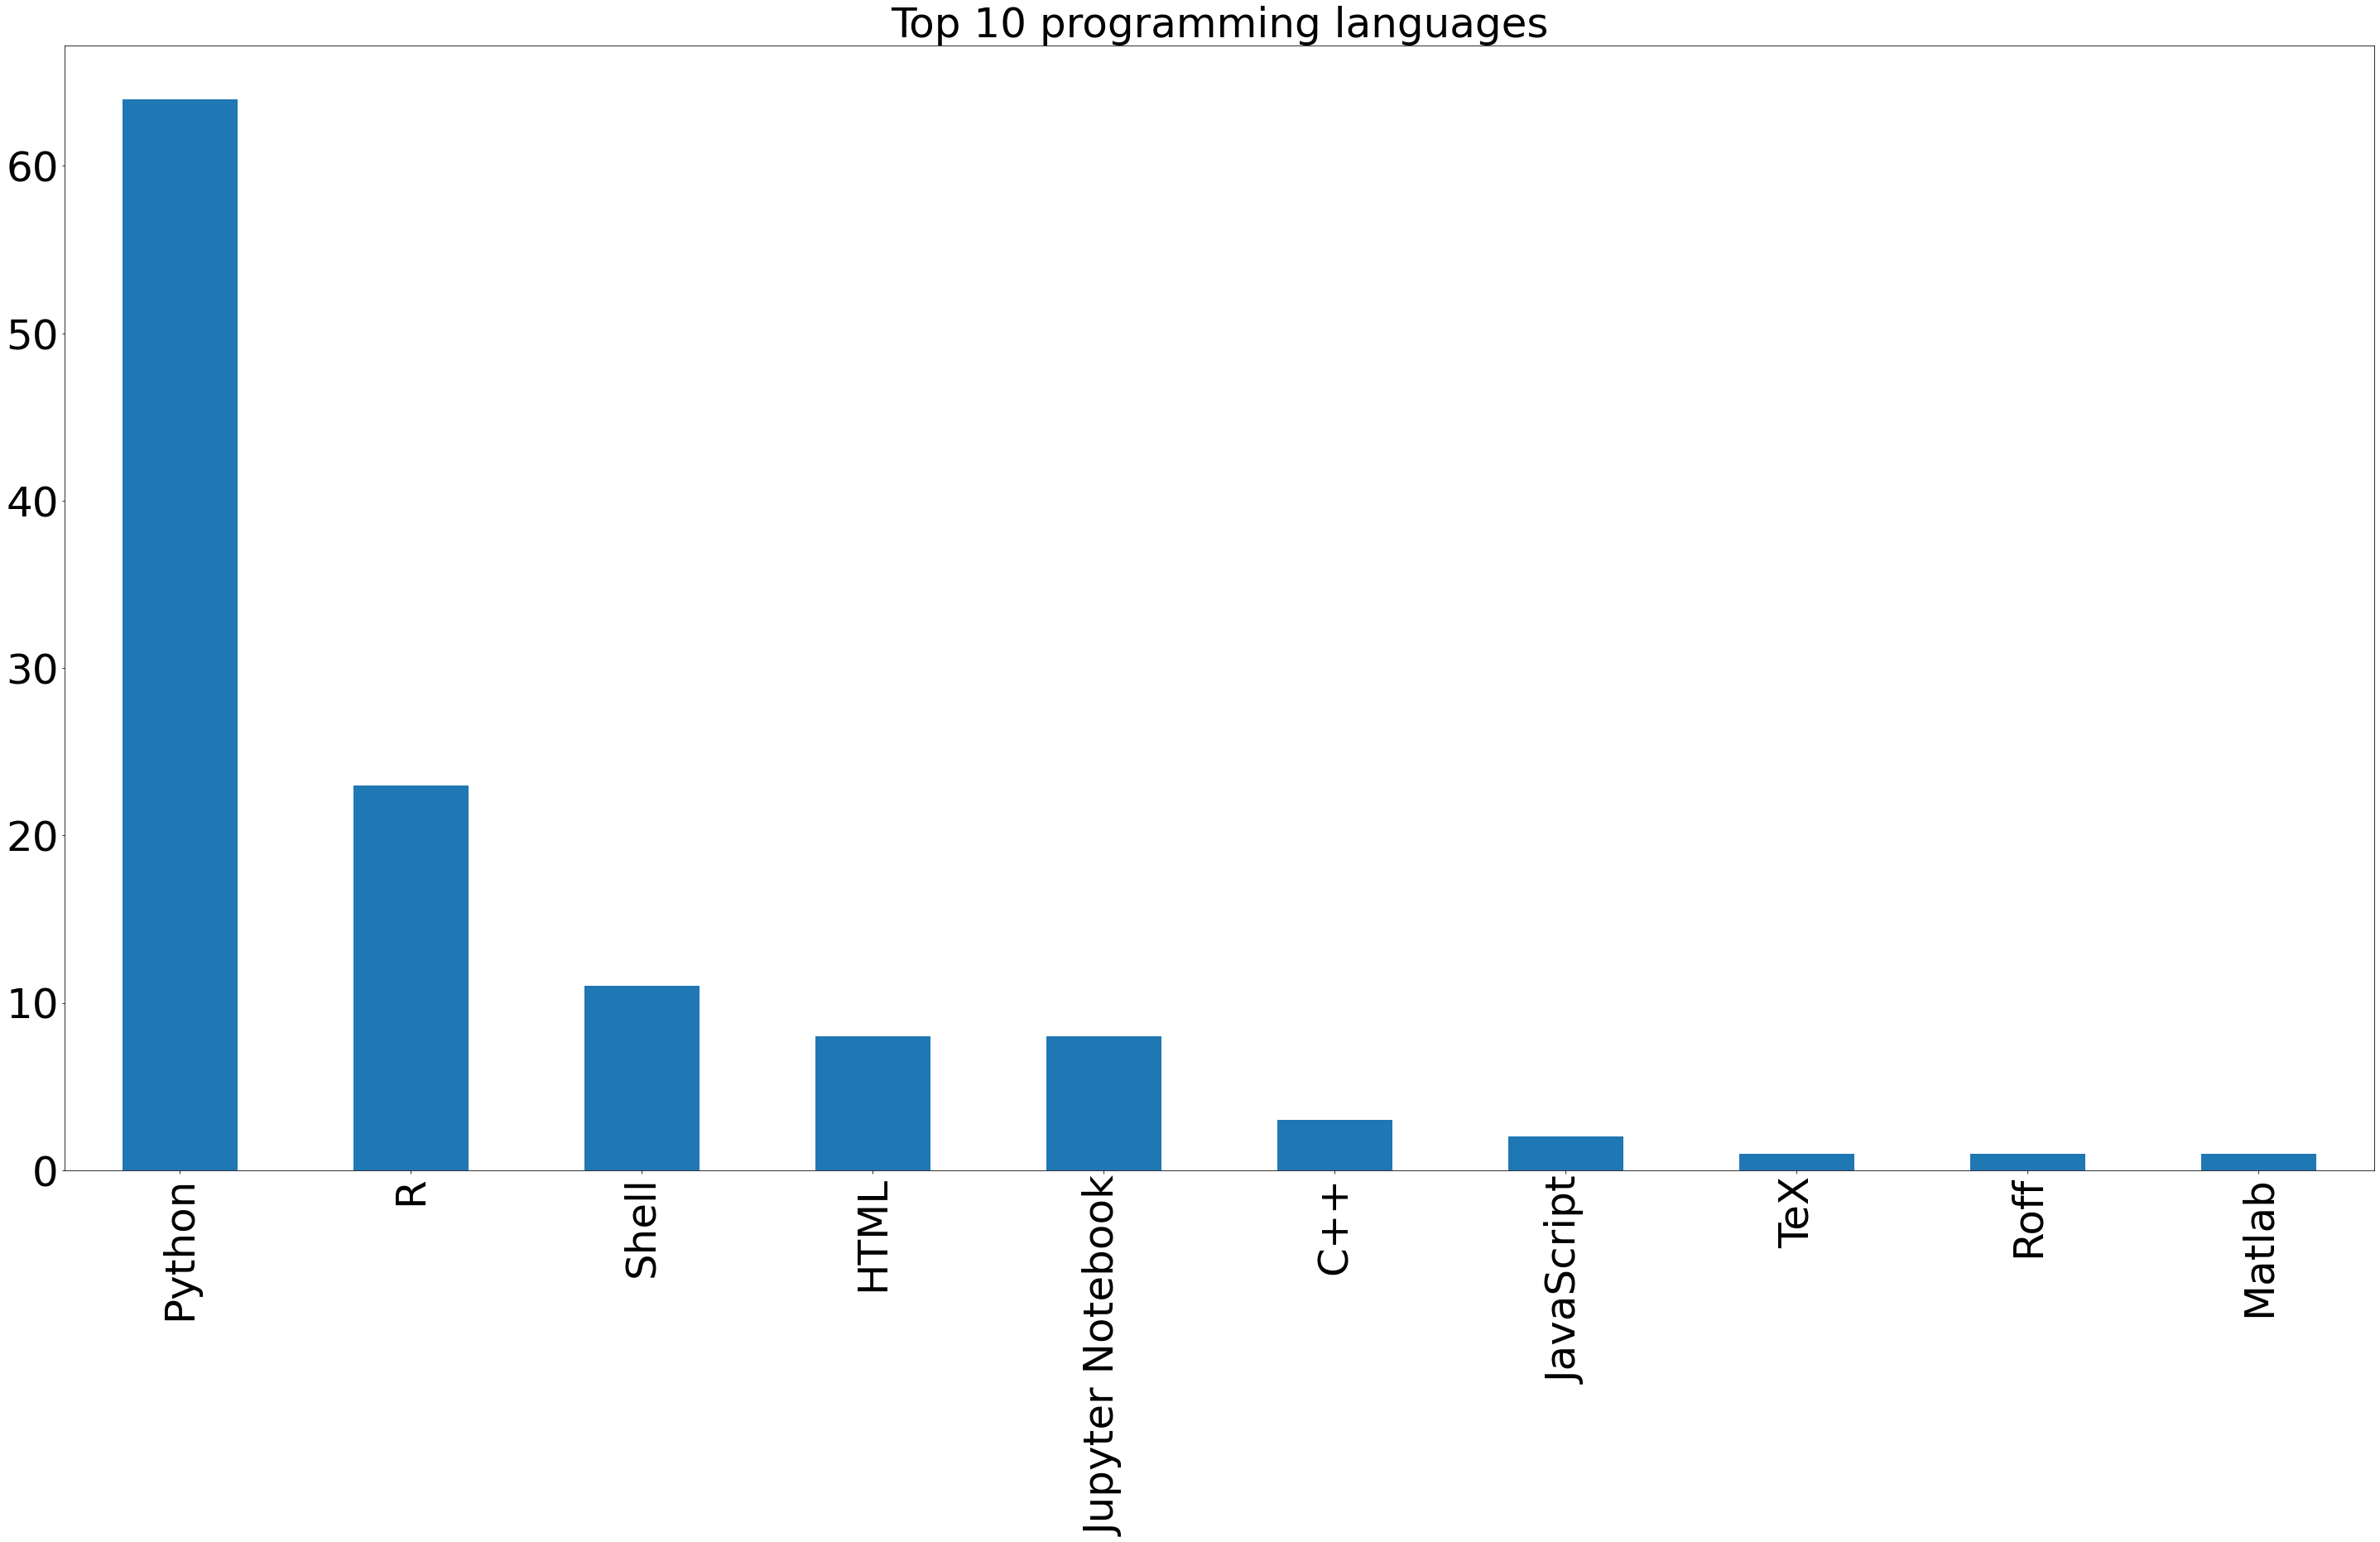

In [24]:
repos["language"].value_counts().head(10).plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_{subset}.png'), bbox_inches="tight")

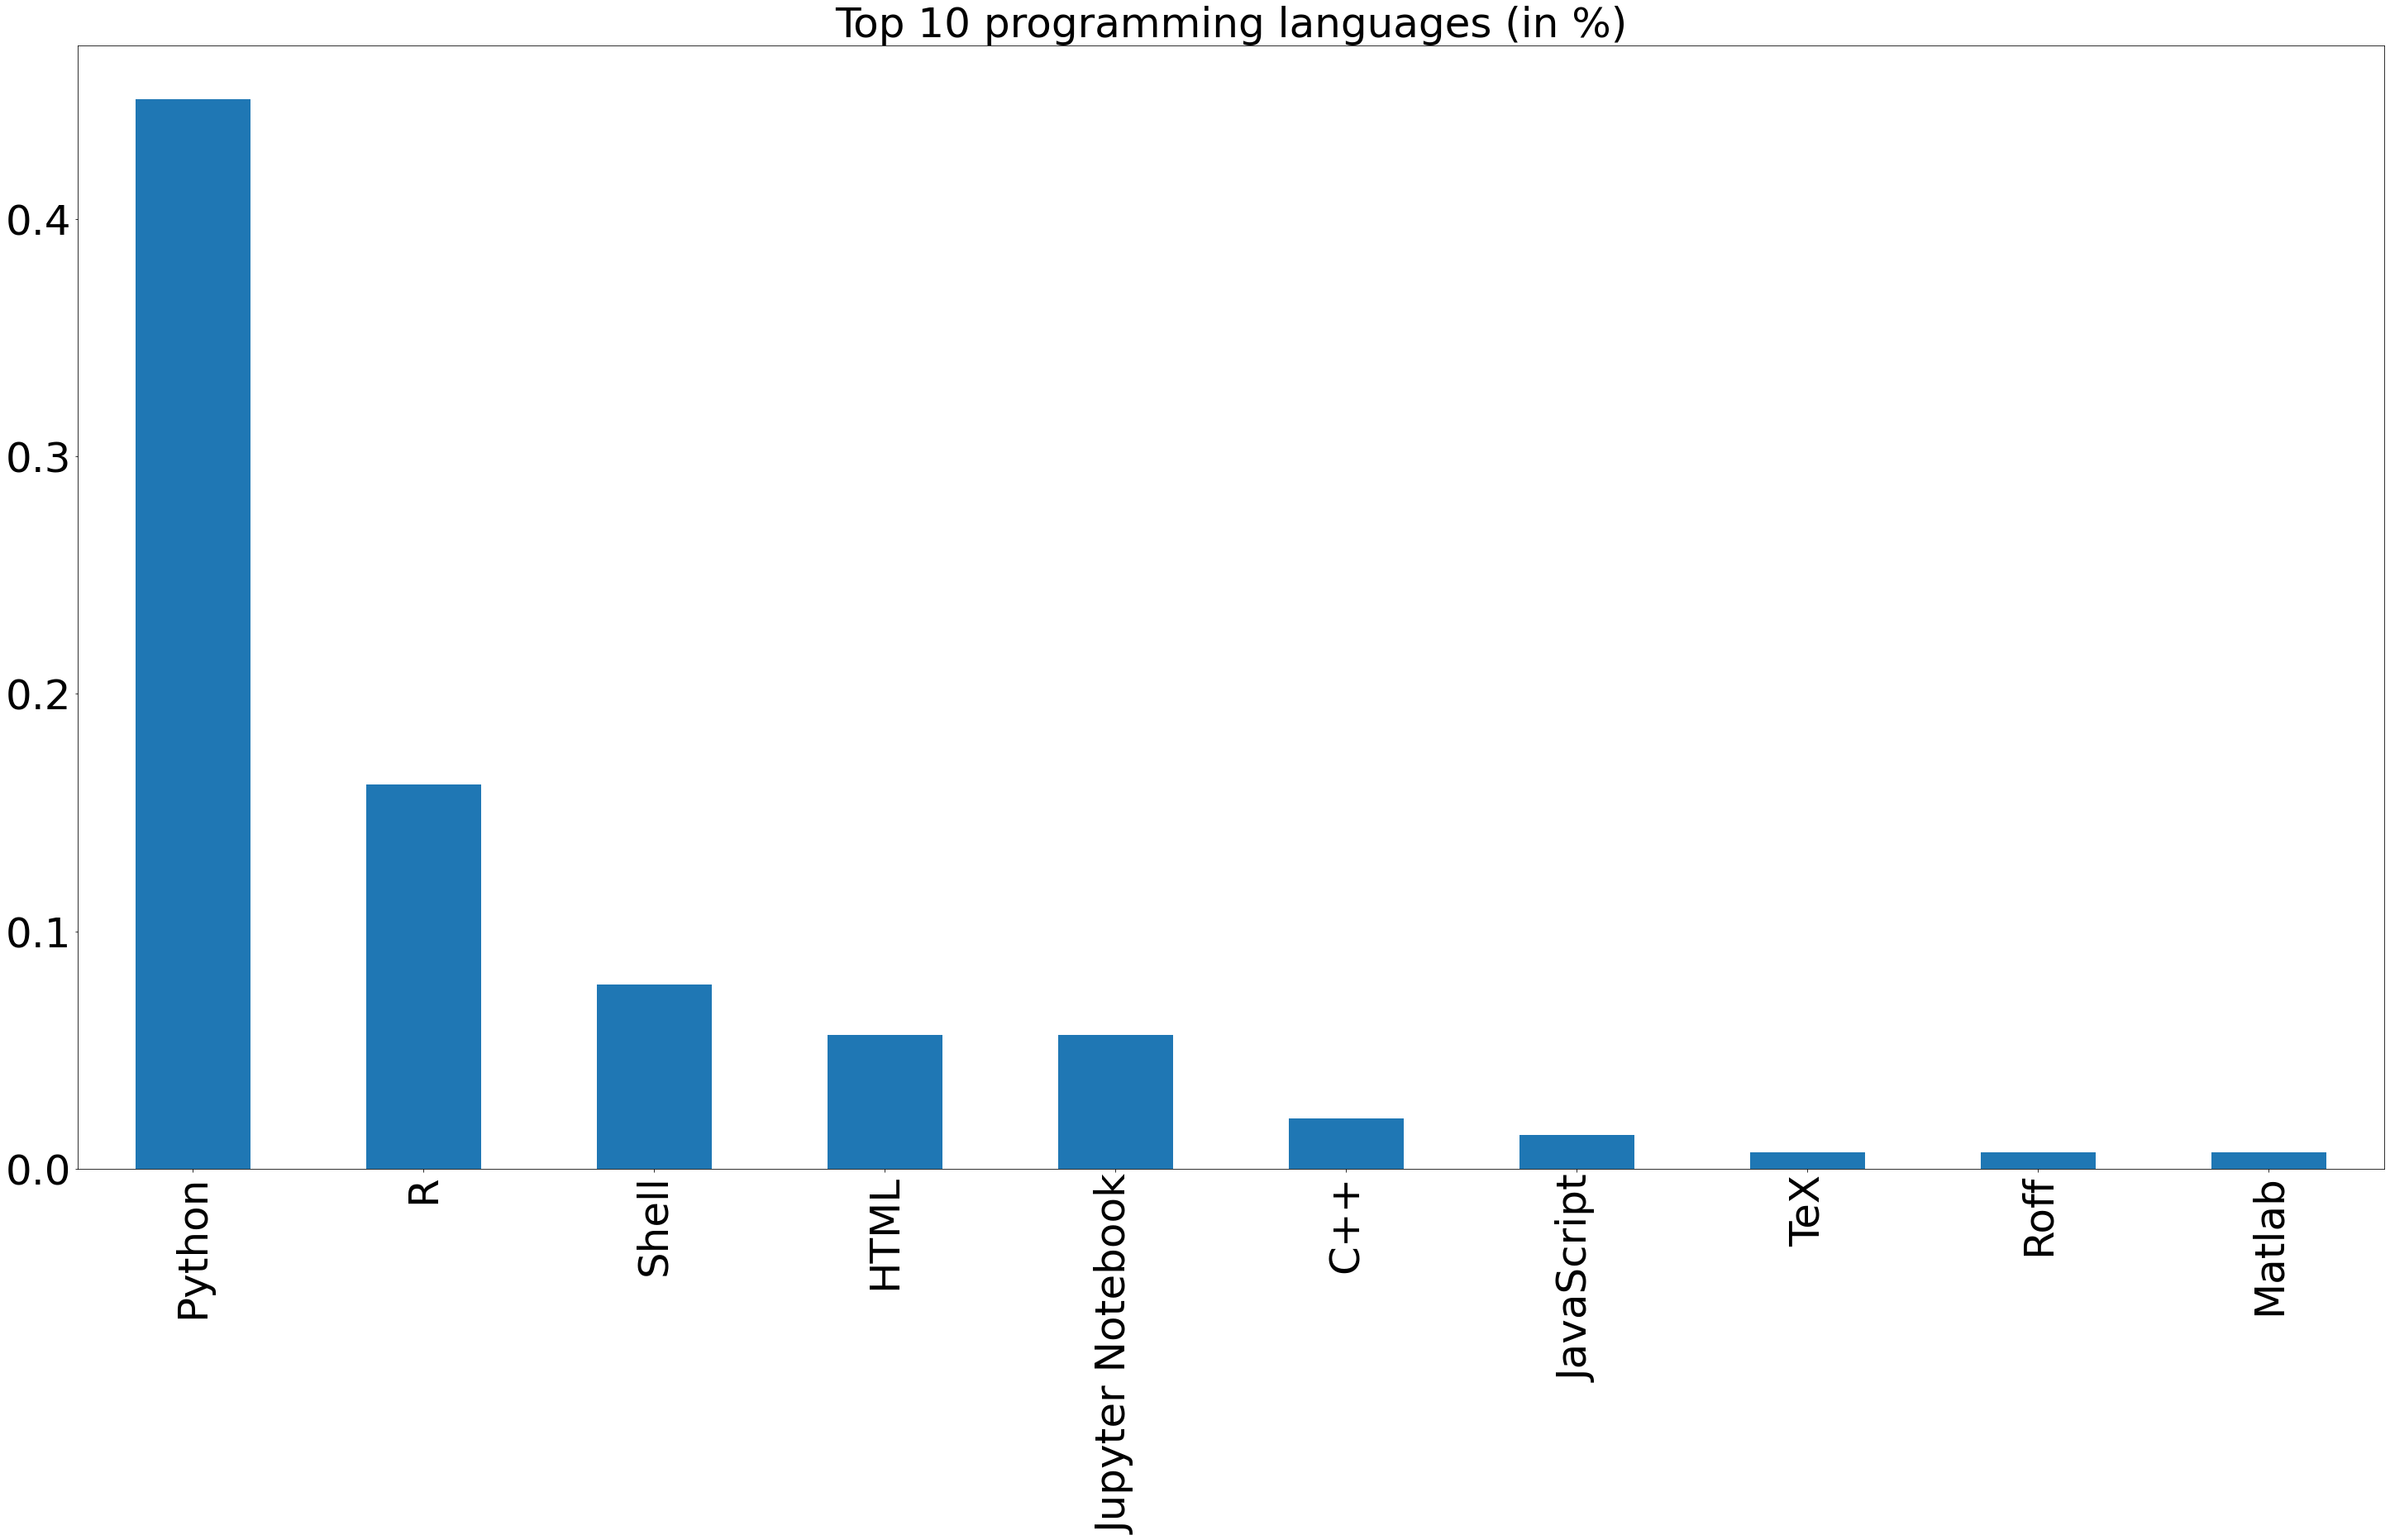

In [25]:
repo_languages_rel = repos["language"].value_counts().head(10) / len(repos)
repo_languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'language_top10_percentage_{subset}.png'), bbox_inches="tight")


## Relative occurence languages

In [26]:
repo_languages_rel

Python              0.450704
R                   0.161972
Shell               0.077465
HTML                0.056338
Jupyter Notebook    0.056338
C++                 0.021127
JavaScript          0.014085
TeX                 0.007042
Roff                0.007042
Matlab              0.007042
Name: language, dtype: float64

## The following percentages represent the percentage of repositories that contains that specific language for the 10 most occuring languages:

In [27]:
for value, language in zip(languages["language"].value_counts().head(10), languages["language"].value_counts().head(10).keys()):
    percentage = value / len(repos) * 100
    print("{} is present in {:.2f} % of all repositories". format(language, percentage))

Python is present in 61.27 % of all repositories
Shell is present in 34.51 % of all repositories
R is present in 24.65 % of all repositories
HTML is present in 12.68 % of all repositories
C++ is present in 9.86 % of all repositories
Makefile is present in 7.75 % of all repositories
Jupyter Notebook is present in 7.75 % of all repositories
TeX is present in 6.34 % of all repositories
CSS is present in 5.63 % of all repositories
CMake is present in 5.63 % of all repositories


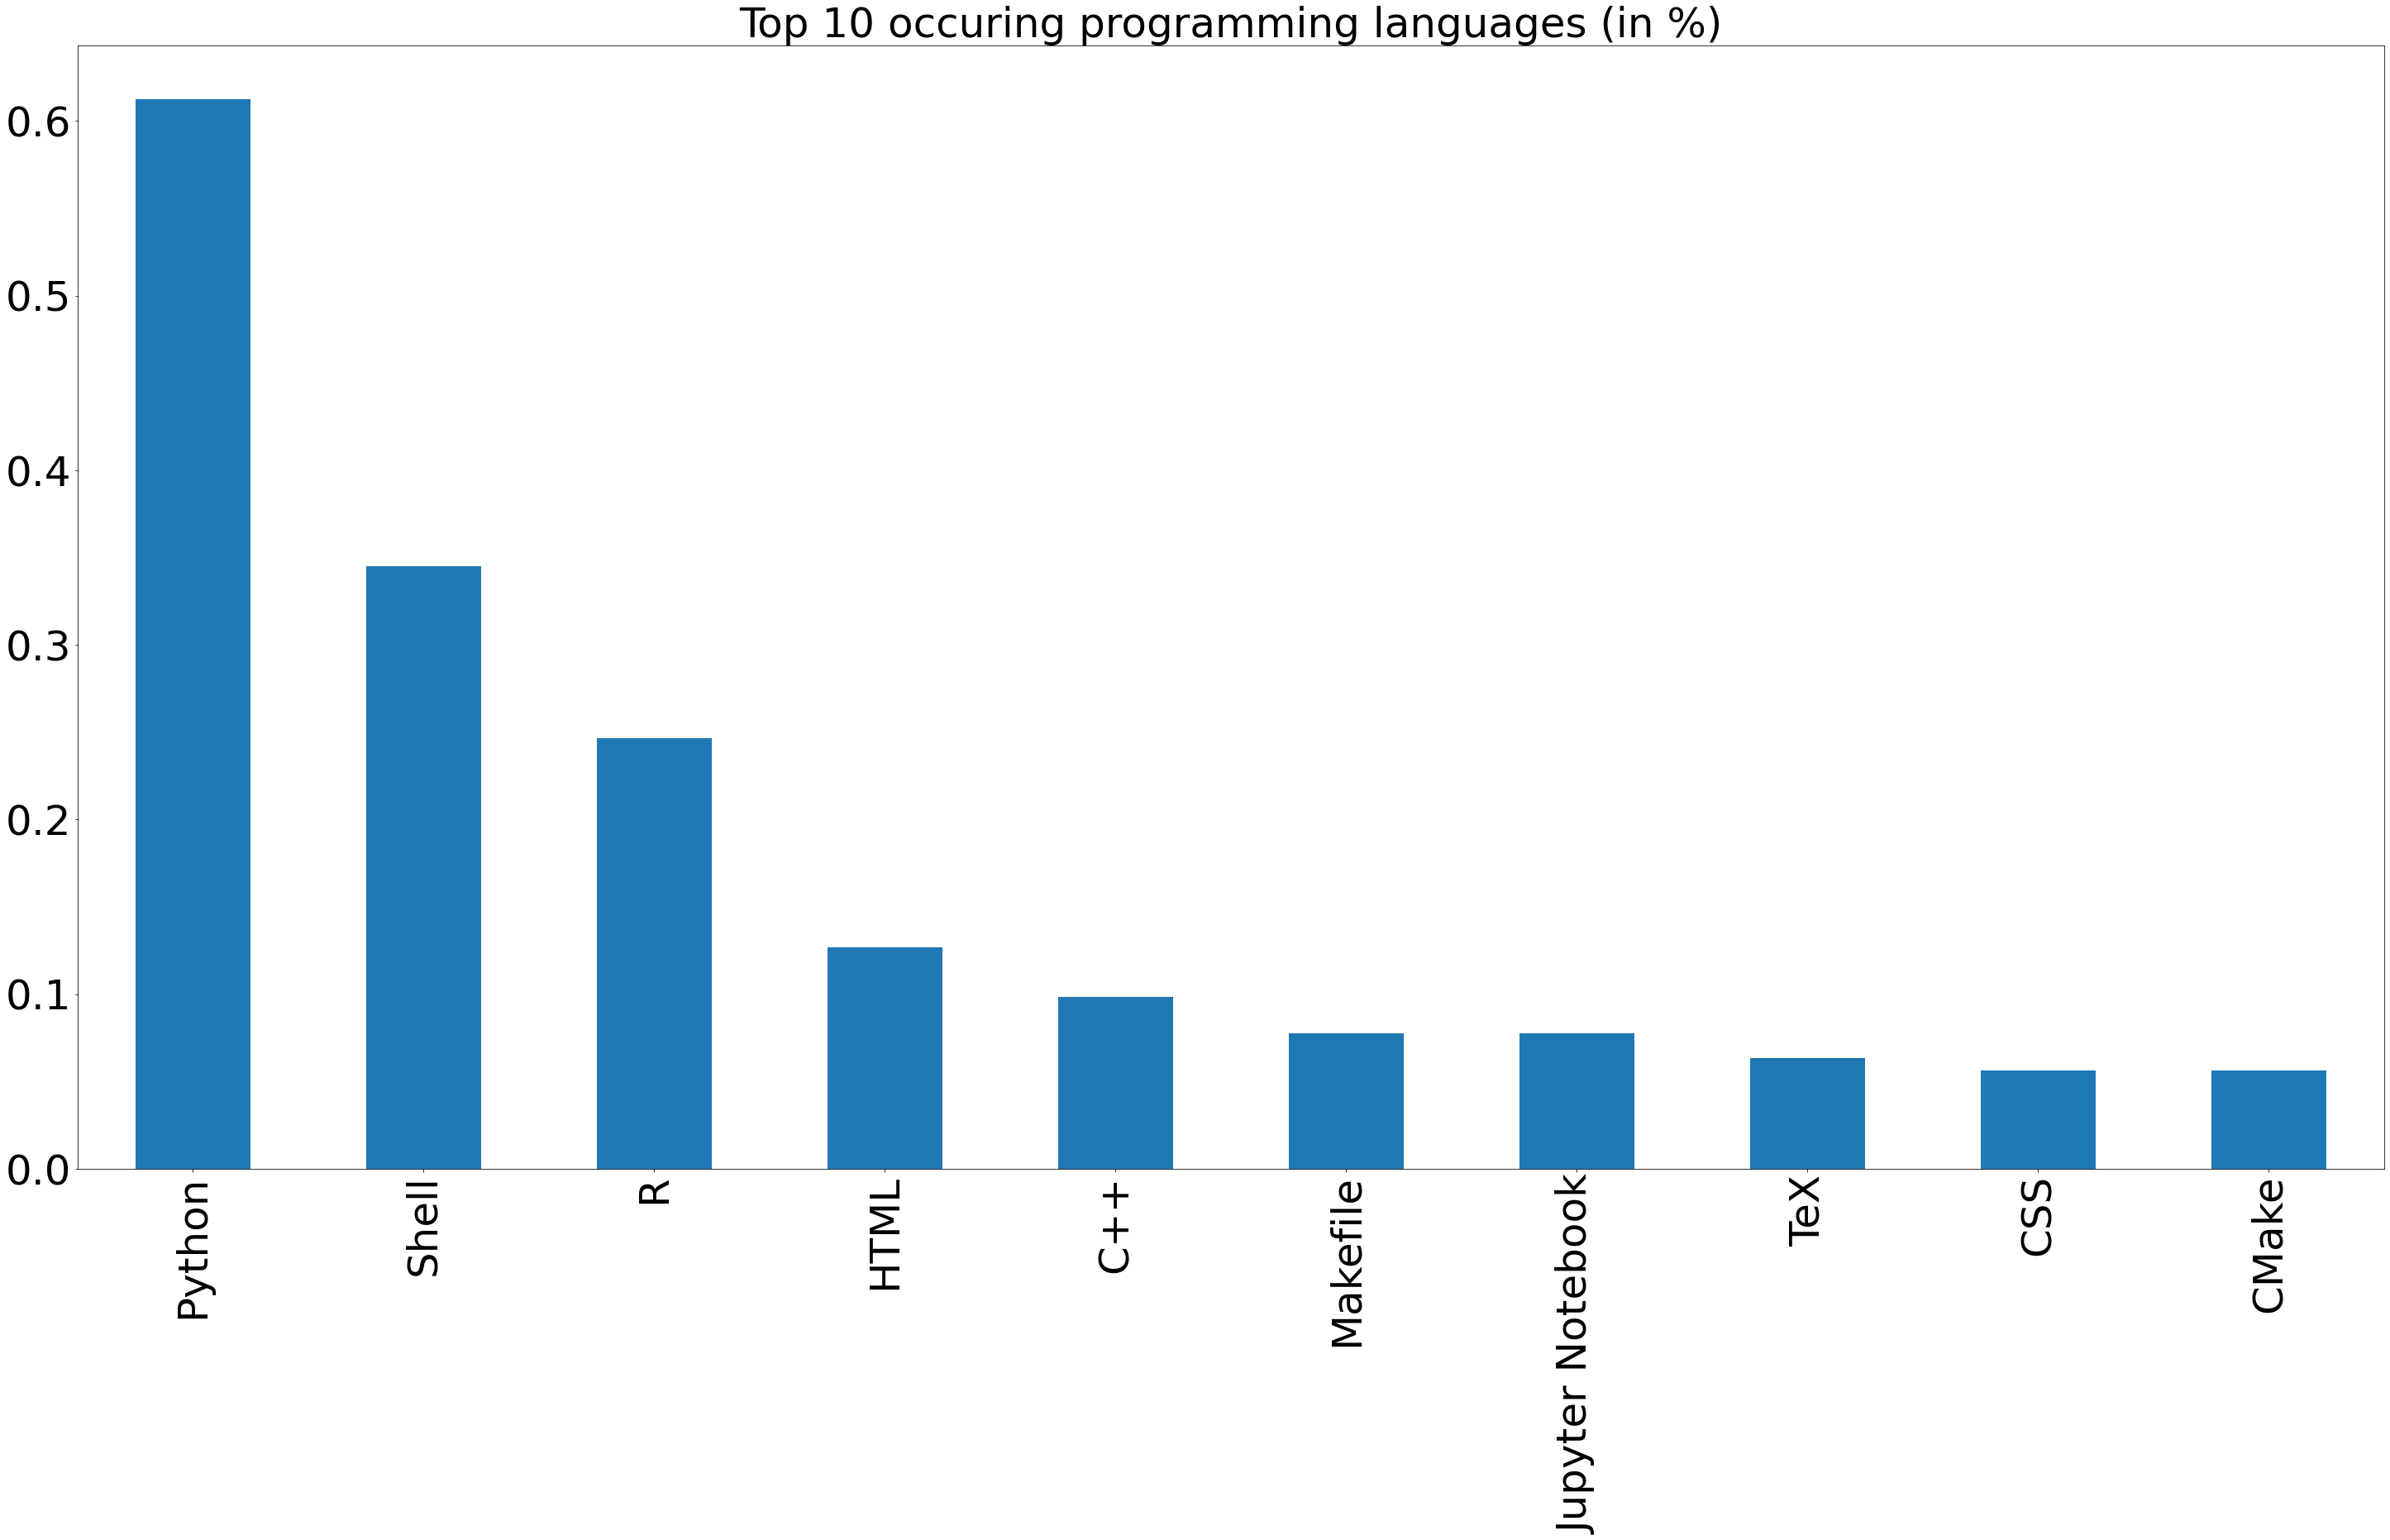

In [28]:
languages_rel = languages["language"].value_counts().head(10) / len(repos)
languages_rel.plot.bar(figsize = (50,25), fontsize = 50)
plt.title("Top 10 occuring programming languages (in %)", fontsize = 50)
plt.savefig(Path(fp_figs, f'occurence_language_top10_percentage_{subset}.png'), bbox_inches="tight")


In [29]:
languages["user"] = languages["html_url_repository"].map(lambda url: url.split("/")[3]) # extract user from url
languages["repo"] = languages["html_url_repository"].map(lambda url: url.split("/")[4]) # extract user from url
unique_users = set(languages["user"])
userlang_chars = dict()
for user in unique_users:
    repos_user = languages.loc[languages['user'] == user]
    repos_user_total_chars = sum(repos_user["num_chars"])
    for index, row in repos_user.iterrows():
        key = row[1] # select language
        if key not in userlang_chars:
            userlang_chars[key] = row["num_chars"]/repos_user_total_chars
        else:
            userlang_chars[key] += row["num_chars"]/repos_user_total_chars

### The following shows a plot with stacked percentage of language usage of a user
#### E.g.: User X has 100 repos written in Python --> Add 1.0 to Python bar. User Y has 1 repo written in R and 1 in C# --> Add 0.5 to R and 0.5 to C#

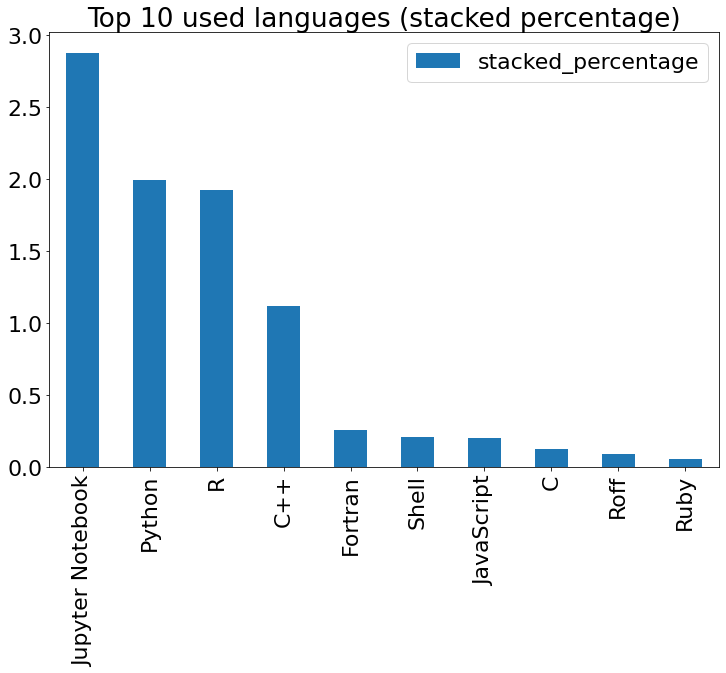

In [30]:
userlang_df = pd.DataFrame.from_dict(userlang_chars, orient="index", columns=['stacked_percentage'])
userlang_df.drop(["HTML", "TeX"], inplace = True)
userlang_df.sort_values(by="stacked_percentage", ascending = False, inplace = True)
userlang_df.head(10).plot(kind = 'bar', title = 'Top 10 used languages (stacked percentage)')
plt.savefig(Path(fp_figs, f'most_occuring_languages_stacked_percent_top10_{subset}.png'), bbox_inches="tight")

## Correlation table top 10 languages

In [31]:
languages["language"].value_counts().head(10).keys()
dict_languages_user = Counter()
dict_top_languages = dict()
for language in languages["language"].value_counts().head(10).keys():
    dict_top_languages[language] = 0

In [32]:
dict_users = {}

In [33]:

for html_url in repos['html_url']: 
    #print(html_url)
    rows_language_for_one_user = languages.loc[languages['html_url_repository'] == html_url]
    dict_languages_user = Counter()
    for language in languages["language"].value_counts().head(10).keys(): #set all values of languages that need to be present to create a dataset in a later stage to zero
        dict_languages_user[language] = 0
    for language in rows_language_for_one_user['language']:
        if language in dict_languages_user: #only count languages in the top 10
            dict_languages_user[language] += 1
    dict_users[html_url] = dict_languages_user #each user has a dict with 10 booleans representing whether the top 10 language is present in their repo or not


In [34]:
languages_per_repo = pd.DataFrame.from_dict(dict_users, orient = 'index')

In [35]:
languages_per_repo.corr().round(decimals = 2)

,Python,Shell,R,HTML,C++,Makefile,Jupyter Notebook,TeX,CSS,CMake
Python,1.00,0.30,-0.45,-0.04,0.07,0.12,0.23,-0.21,0.01,0.07
Shell,0.30,1.00,-0.17,-0.01,0.26,0.29,-0.04,-0.07,0.08,0.21
R,-0.45,-0.17,1.00,0.08,-0.08,-0.17,-0.04,0.32,0.07,-0.14
HTML,-0.04,-0.01,0.08,1.00,0.09,0.13,-0.11,0.16,0.55,0.09
C++,0.07,0.26,-0.08,0.09,1.00,0.61,-0.10,0.11,0.12,0.43
Makefile,0.12,0.29,-0.17,0.13,0.61,1.00,-0.08,0.03,0.16,0.27
Jupyter Notebook,0.23,-0.04,-0.04,-0.11,-0.10,-0.08,1.00,-0.08,-0.07,-0.07
TeX,-0.21,-0.07,0.32,0.16,0.11,0.03,-0.08,1.00,0.19,0.06
CSS,0.01,0.08,0.07,0.55,0.12,0.16,-0.07,0.19,1.00,0.07
CMake,0.07,0.21,-0.14,0.09,0.43,0.27,-0.07,0.06,0.07,1.00


## Topics

Topics describe the context of the repository. 

In [36]:
topics['topic'].value_counts().nlargest(50)

asreview                         22
james-server                     10
utrecht-university               10
growth-curves                     9
systematic-reviews                8
growth-charts                     6
systematic-literature-reviews     5
active-learning                   5
python                            5
imputation                        4
mice                              4
anthropometry                     4
dutch                             3
simulation                        3
mega-meta                         3
machine-learning                  3
chained-equations                 3
research                          3
missing-data                      2
systematic-reviews-datasets       2
netherlands                       2
restful-api                       2
datashield                        2
feature-extraction                2
covid-19                          2
plugin                            2
growth-standards                  2
deep-learning               

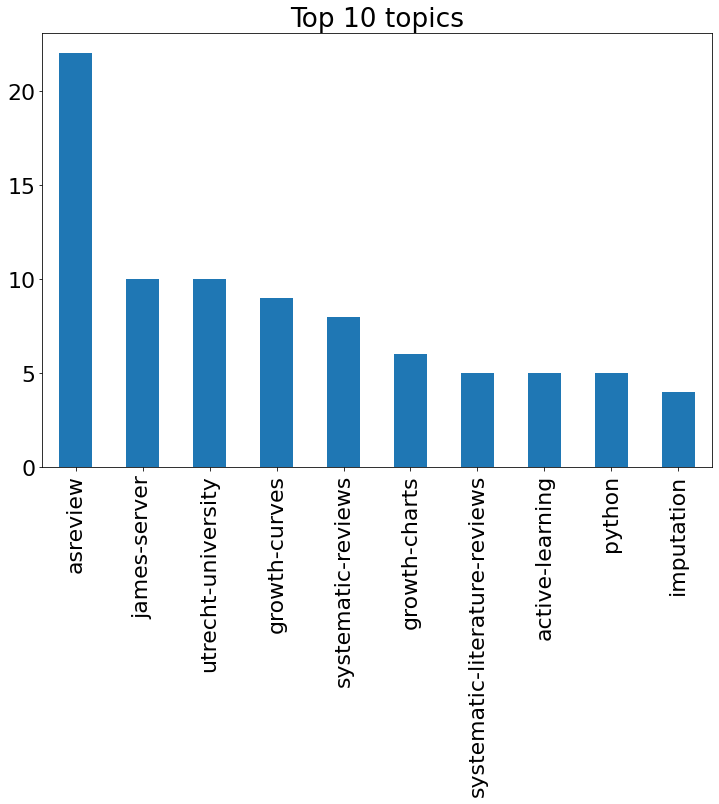

In [37]:
topics['topic'].value_counts().nlargest(10).plot(kind = 'bar', title = 'Top 10 topics')
plt.savefig(Path(fp_figs, f'most_occuring_topics_top10_{subset}.png'), bbox_inches="tight")


## Number of  contributors

The number of contributors gives information on how many people put effort into the repository. Theoratically, it would make sense if a higher amount of contributors implied a more FAIR repository, because those are easier to find in a registery and work on because of their license. 


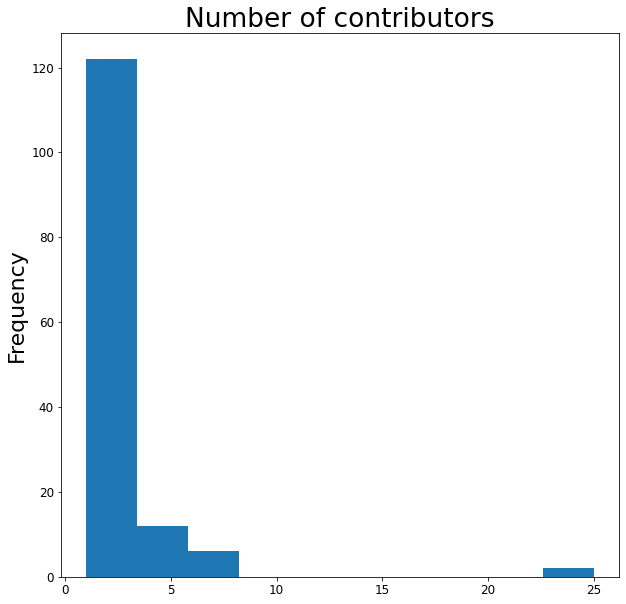

In [38]:
contributors['html_url_repository'].value_counts().plot.hist(x = 'contributors', figsize = (10,10), fontsize = 12, title = 'Number of contributors')
plt.savefig(Path(fp_figs, f'contributors_{subset}.png'), bbox_inches="tight")


In [39]:
contributors['html_url_repository'].value_counts().nlargest(20, keep = 'all')


https://github.com/asreview/asreview                                          25
https://github.com/amices/mice                                                24
https://github.com/haddocking/haddock-tools                                    8
https://github.com/asreview/systematic-review-datasets                         7
https://github.com/haddocking/pdb-tools                                        6
https://github.com/haddocking/powerfit                                         6
https://github.com/haddocking/prodigy                                          6
https://github.com/asreview/asreview-covid19                                   6
https://github.com/haddocking/prodigy-cryst                                    5
https://github.com/haddocking/whiscy                                           5
https://github.com/haddocking/haddock3                                         5
https://github.com/asreview/asreview-wordcloud                                 5
https://github.com/haddockin

In [40]:
print('mean contributors: {:.2f}'.format(statistics.mean(contributors['html_url_repository'].value_counts())))
print('median contributors: {}'.format(statistics.median(contributors['html_url_repository'].value_counts())))

mean contributors: 2.41
median contributors: 2.0


## Howfairis sum score descriptives and correlations

In this section, the median and meand of the howfairis sum score is shown, as well as correlations the how fair is sum score, the amount of contributors and the amount of months since the last commit

In [41]:
how_fair_sum_scores = []
for index, row in how_fair_is.iterrows():
    how_fair_is_sum = row['howfairis_repository'] + row['howfairis_license'] +row['howfairis_registry'] + row['howfairis_citation'] + row['howfairis_checklist']
    how_fair_sum_scores.append(how_fair_is_sum)

mean: 1.88
median: 2.0


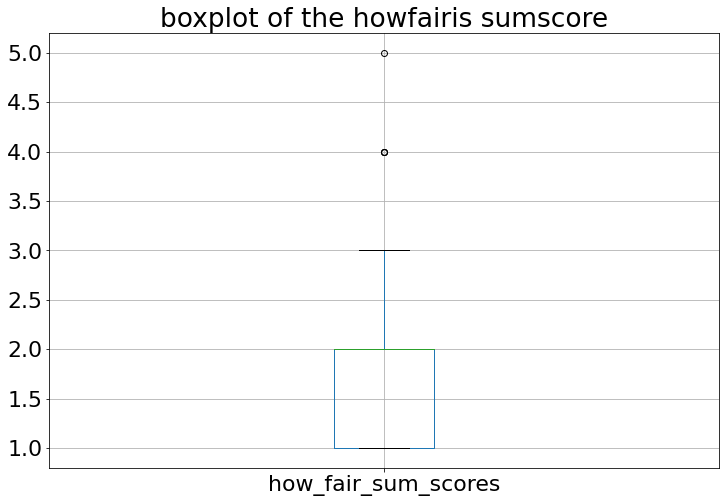

In [42]:
how_fair_is['how_fair_sum_scores'] = how_fair_sum_scores
print("mean: {:.2f}".format(statistics.mean(how_fair_sum_scores)))
print("median: {}".format(statistics.median(how_fair_sum_scores)))
pd.DataFrame((statistics.mean(how_fair_sum_scores), statistics.median(how_fair_sum_scores)),["mean", "median"])
how_fair_is.boxplot(column = 'how_fair_sum_scores')
plt.title('boxplot of the howfairis sumscore')
plt.savefig(Path(fp_figs, f'howfairissum_boxplot_{subset}.png'), bbox_inches="tight")


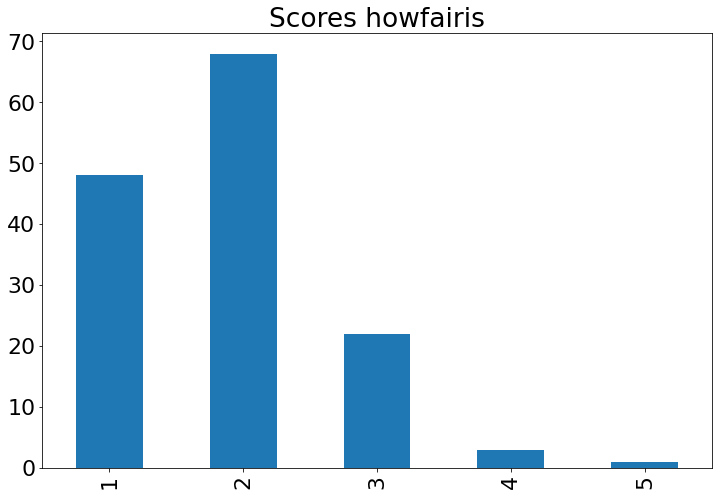

In [43]:
how_fair_is['how_fair_sum_scores'].value_counts().sort_index().plot.bar(title = 'Scores howfairis')
plt.savefig(Path(fp_figs, f'howfairissum_histogram_{subset}.png'), bbox_inches="tight")

In [44]:
correlation_df = pd.DataFrame()
months_ago_most_recent_commit =[]
today = str(date.today())
split_today = today.split('-')
for date_item in repos['updated_at']:
    split_date = date_item.split('-')
    years_ago = int(split_today[0]) - int(split_date[0])
    months_ago = 12 * years_ago + (int(split_today[1]) - int(split_date[1]))
    months_ago_most_recent_commit.append(months_ago)
repos['months_ago_most_recent_commit'] = months_ago_most_recent_commit

In [45]:
correlation_df['how_fair_sum_scores'] = how_fair_sum_scores
correlation_df['contributions']= contributors['contributions']
correlation_df['months_ago_most_recent_commit'] = repos['months_ago_most_recent_commit']

In [46]:
correlation_df.corr(method='pearson').round(decimals=2)

,how_fair_sum_scores,contributions,months_ago_most_recent_commit
how_fair_sum_scores,1.00,NaN,0.01
contributions,NaN,NaN,NaN
months_ago_most_recent_commit,0.01,NaN,1.00


In [47]:
unique_users = set(how_fair_is["owner"])
unique_users
howfairis_max_user = list()
howfairis_average = list()
for user in unique_users:
    repos_user = how_fair_is.loc[how_fair_is['owner'] == user]
    howfairis_max_user.append(max(repos_user["how_fair_sum_scores"]))
    num_repos = len(repos_user.index)
    average = sum(repos_user["how_fair_sum_scores"])/num_repos
    howfairis_average.append([average, num_repos])

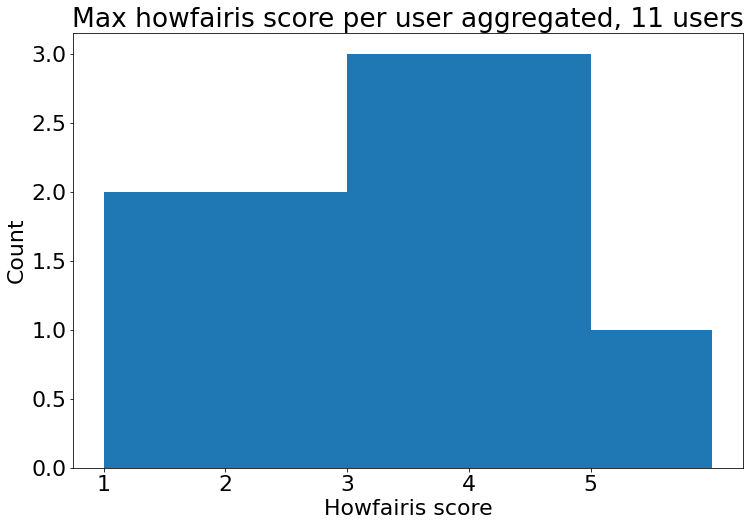

In [48]:
plt.hist(howfairis_max_user, bins = range(1,7))
plt.xticks(range(1,6))
plt.ylabel('Count')
plt.xlabel('Howfairis score')
plt.title("Max howfairis score per user aggregated, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_stacked_max{subset}.png'), bbox_inches="tight")

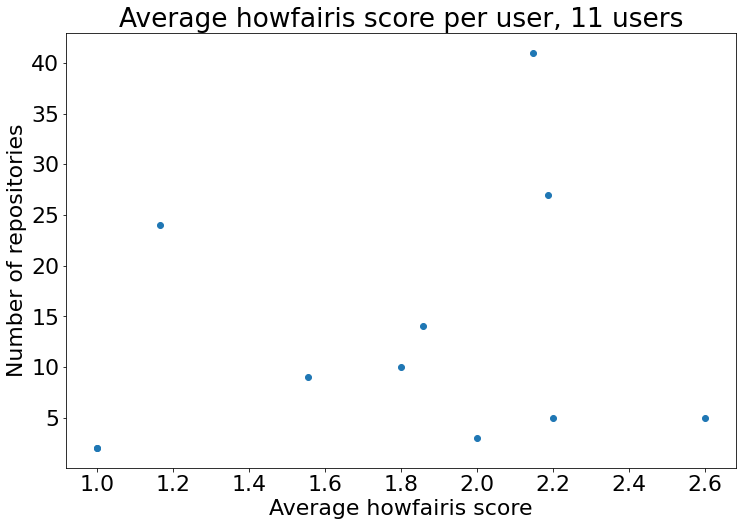

In [49]:
plt.scatter(*zip(*howfairis_average))
plt.ylabel('Number of repositories')
plt.xlabel('Average howfairis score')
plt.title("Average howfairis score per user, " + str(len(unique_users)) + " users")
plt.savefig(Path(fp_figs, f'howfairis_scatter_repos_avg{subset}.png'), bbox_inches="tight")

## Binary correlation plot between howfairis variables

A correlation table that shows the correlation between the howfairis measures.

In [50]:
correlation_how_fair_is = pd.DataFrame()

#correlation_how_fair_is['howfairis_repository'] = how_fair_is['howfairis_repository']
correlation_how_fair_is['howfairis_license'] = how_fair_is['howfairis_license']
correlation_how_fair_is['howfairis_registry'] = how_fair_is['howfairis_registry']
correlation_how_fair_is['howfairis_citation'] = how_fair_is['howfairis_citation']
correlation_how_fair_is['howfairis_checklist'] = how_fair_is['howfairis_checklist']



In [51]:
correlation_how_fair_is.corr(method='pearson').round(decimals=2) #howfairis_repository is all true, so has no variance

,howfairis_license,howfairis_registry,howfairis_citation,howfairis_checklist
howfairis_license,1.00,0.11,0.31,0.09
howfairis_registry,0.11,1.00,0.15,0.23
howfairis_citation,0.31,0.15,1.00,0.28
howfairis_checklist,0.09,0.23,0.28,1.00


## Programming language and Howfairis

Different programming languages need different licences. For some languages (e.g. python), these are more complex. How does this influence the HowFairis score?

In [52]:
index_how_fair_is = 0
language_how_fair_is_df = []
#get a list with the how-fair-is scores added to the language dataset
for index,row in languages.iterrows():
    if how_fair_is['html_url'][index_how_fair_is] != languages['html_url_repository'][index]:
        index_how_fair_is += 1 
    sum_score = how_fair_is['how_fair_sum_scores'][index_how_fair_is]
    language_how_fair_is_df.append(sum_score)
regression_data_how_fair_is_language = pd.DataFrame()
language_data_dummies = pd.get_dummies(languages['language'])  #one hot-encoding for language dataset
regression_data_how_fair_is_language['how_fair_is_sum'] = language_how_fair_is_df
languages['how_fair_sum_scores'] = regression_data_how_fair_is_language #add scores to language dataset

KeyError: 0

In [ ]:
train_size = int(len(languages) * 0.8) #training size is 2227, testing size is  557
regression_how_fair_is_language_train_X = language_data_dummies[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_data_dummies[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [ ]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
#print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


In [ ]:
language_subset = language_data_dummies[['Python', 'Shell', 'R', 'JavaScript', 'HTML']] #top 5 languages


In [ ]:
train_size = int(len(language_subset) * 0.8)
regression_how_fair_is_language_train_X = language_subset[:train_size]
regression_how_fair_is_language_train_y = regression_data_how_fair_is_language['how_fair_is_sum'][:train_size]
regression_how_fair_is_language_test_X = language_subset[train_size:]
regression_how_fair_is_language_test_y = regression_data_how_fair_is_language['how_fair_is_sum'][train_size:]

In [ ]:
#train regression
regression_language_how_fair_is = LinearRegression()
regression_language_how_fair_is.fit(regression_how_fair_is_language_train_X, regression_how_fair_is_language_train_y)

# Make predictions using the testing set
language_how_fair_is_y_pred = regression_language_how_fair_is.predict(regression_how_fair_is_language_test_X)

# The coefficients
print('Coefficients: \n', regression_language_how_fair_is.coef_)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(regression_how_fair_is_language_test_y, language_how_fair_is_y_pred))


A simple regression for predicting the how fair is score from  all or a subset of languages does not seem to yield any results 

## Examples of high howfairis scores 

In this section, some links to the pages that have a high howfairis score are shown. 

In [ ]:
how_fair_is_high_scores = how_fair_is[how_fair_is['how_fair_sum_scores'] > 3].sort_values('how_fair_sum_scores', ascending=False)

how_fair_is_high_scores[['html_url', 'how_fair_sum_scores']]

## Re-use of other projects and articles

Are there competitors?
How do they relate to each other?